## Reviewer Calibration

### 30th July 2014 Neil D. Lawrence

In this note book we deal with reviewer calibration. Our assumption is that the score from the $j$th reviwer for the $i$th paper is given by
$$
y_{i,j} = f_i + b_j + \epsilon_{i, j}
$$
where $f_i$ is the 'objective quality' of paper $i$ and $b_j$ is an offset associated with reviewer $j$. $\epsilon_{i,j}$ is a subjective quality estimate which reflects how a specific reviewer's opinion differs from other reviewers (such differences in opinion may be due to differing expertise or perspective). The underlying 'objective quality' of the paper  is assumed to be the same for all reviewers and the reviewer offset is assumed to be the same for all papers.

If we have $n$ papers and $m$ reviewers then this implies $n$ + $m$ + $nm$ values need to be estimated. Naturally this is too many, and we can start by assuming that the subjective quality is drawn from a normal density with variance $\sigma^2$
$$
\epsilon_{i, j} \sim N(0, \sigma^2 \mathbf{I})
$$
which reduces us to $n$ + $m$ + 1 parameters. Further we can assume that the objective quality is also normally distributed with mean $\mu$ and variance $\alpha_f$, 
$$
f_i \sim N(\mu, \alpha_f)
$$
this now reduces us to $m$+3 parameters. However, we only have approximately $4m$ observations (4 papers per reviewer) so parameters may still not be that well determined (particularly for those reviewers that have only one review). We therefore, finally, assume that reviewer offset is normally distributed with zero mean, 
$$
b_j \sim N(0, \alpha_b),
$$
leaving us only four parameters: $\mu$, $\sigma^2$, $\alpha_f$ and $\alpha_b$. Combined together these three assumptions imply that
$$
\mathbf{y} \sim N(\mu \mathbf{1}, \mathbf{K})
$$
where $\mathbf{y}$ is a vector of stacked scores $\mathbf{1}$ is the vector of ones and the elements of the covariance function are given by
$$
k(i,j; k,l) = \delta_{i,k} \alpha_f + \delta_{j,l} \alpha_b + \delta_{i, k}\delta_{j,l} \sigma^2
$$
where $i$ and $j$ are the index of first paper and reviewer and $k$ and $l$ are the index of second paper and reviewer.
The mean is easily estimated by maximum likelihood, and is given as the mean of all scores. 

It is convenient to reparameterize slightly into an overall scale $\alpha_f$, and normalized variance parameters,
$$
k(i,j; k,l) = \alpha_f(\delta_{i,k}  + \delta_{j,l} \frac{\alpha_b}{\alpha_f} + \delta_{i, k}\delta_{j,l} \frac{\sigma^2}{\alpha_f})
$$
which we rewrite to give two ratios: offset/signal ratio, $\hat{\alpha}_b$ and noise/signal $\hat{\sigma}^2$ ratio. 
$$
k(i,j; k,l) = \alpha_f(\delta_{i,k}  + \delta_{j,l} \hat{\alpha}_b + \delta_{i, k}\delta_{j,l} \hat{\sigma}^2)
$$
The advantage of this parameterization is it allows us to optimize $\alpha_f$ directly (with a fixed point equation) and it will be very well determined. This leaves us with two free parameters, that we can explore on the grid. It is in these parameters that we expect the remaining underdetermindness of the model. We expect $\alpha_f$ to be well determined because the negative log likelihood is now
$$
\frac{|\mathbf{y}|}{2}\log\alpha_f + \frac{1}{2}\log  \left|\hat{\mathbf{K}}\right| + \frac{1}{2\alpha_f}\mathbf{y}^\top \hat{\mathbf{K}}^{-1} \mathbf{y}
$$
where $|\mathbf{y}|$ is the length of $\mathbf{y}$ (i.e. the number of reviews) and $\hat{\mathbf{K}}=\alpha_f^{-1}\mathbf{K}$ is the scale normalised covariance. This negative log likelihood is easily minimized to recover
$$
\alpha_f = \frac{1}{|\mathbf{y}|} \mathbf{y}^\top \hat{\mathbf{K}}^{-1} \mathbf{y}
$$
A Bayesian analysis of this parameter is possible with gamma priors, but it would merely shows that this parameter is extremely well determined (the degrees of freedom parameter of the associated Student-$t$ marginal likelihood scales will the number of reviews, which will be around $|\mathbf{y}| \approx 6,000$ in our case.

So, we propose to proceed as follows. Set the mean from the reviews ($\mu$) and then choose a two dimensional grid of parameters for reviewer offset and diversity. For each parameter choice, optimize to find $\alpha_f$ and then evaluate the liklihood. Worst case this will require us inverting $\hat{\mathbf{K}}$, but if the reviewer paper groups are disconnected, it can be done a lot quicker. Next stage is to load in the reviews for analysis.

In [ ]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/sods/conference/master/cmtutils.py','cmtutils.py')

In [ ]:
%pip install gpy
%pip install --upgrade git+https://github.com/sods/ods

In [5]:
import cmtutils
import os
import pandas as pd
import numpy as np
import GPy
from scipy.sparse.csgraph import connected_components
from scipy.linalg import solve_triangular 

date = '2014-09-06'

## Loading in the Data

In [6]:
filename = date + '_reviews.xls'
reviews = cmtutils.cmt_reviews_read(filename=filename)
papers = list(sorted(set(reviews.reviews.index), key=int))
reviews.reviews = reviews.reviews.loc[papers]

The maximum likelihood solution for $\mu$ is simply the mean quality of the papers, this is easily computed.

In [7]:
mu = reviews.reviews.Quality.mean()
print("Mean value, mu = ", mu)

Mean value, mu =  5.200867835834388


## Data Preparation

We take the reviews, which are indexed by the paper number, and create a new data frame, that indexes by paper id and email combined. From these reviews we tokenize the `PaperID` and the `Email` to extract two matrices that can be used in creation of covariance matrices. We also create a target vector which is the mean centred vector of scores.

In [16]:
r = reviews.reviews.reset_index()
r.rename(columns={'ID':'PaperID'}, inplace=True)
r.index = r.PaperID + '_' + r.Email
X1 = pd.get_dummies(r.PaperID)
X1 = X1[sorted(X1.columns, key=int)]
X2 = pd.get_dummies(r.Email)
X2 = X2[sorted(X2.columns, key=str.lower)]
y = reviews.reviews.Quality - mu

### Constructing the Model in GPy

Having reduced the model to two parameters, I was hopeful I could set parameters broadly by hand. My initial expectation was that `alpha_b` and `sigma2` would both be less than 1, but some playing with parameters showed this wasn't the case. Rather than waste further time, I decided to use our [`GPy` Software](https://github.com/SheffieldML/GPy) (see below) to find a maximum likelihood solution for the parameters.

Model construction firstly involves constructing covariance functions for the model and concatanating `X1` and `X2` to a new input matrix `X`.

In [17]:
X = X1.join(X2)
kern1 = GPy.kern.Linear(input_dim=len(X1.columns), active_dims=np.arange(len(X1.columns)))
kern1.name = 'K_f'
kern2 = GPy.kern.Linear(input_dim=len(X2.columns), active_dims=np.arange(len(X1.columns), len(X.columns)))
kern2.name = 'K_b'

Next, the covariance function is used to create a Gaussian process regression model with `X` as input and `y` as target. The covariance function is given by $\mathbf{K}_f + \mathbf{K}_b$.

In [18]:
model = GPy.models.GPRegression(X, y[:, None], kern1+kern2)
model.optimize()

Now we can check the parameters of the result.

In [20]:
print(model)
print(model.log_likelihood())


Name : GP regression
Objective : 10071.679092815619
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  sum.K_f.variances        |  1.2782303448777643  |      +ve      |        
  sum.K_b.variances        |  0.2400098787580176  |      +ve      |        
  Gaussian_noise.variance  |   1.268365689279675  |      +ve      |        
-10071.679092815619


### Construct the Model Without GPy

The answer from the GPy solution is introduced here, alongside the code where the covariance matrices are explicitly created (above they are created using GPy's high level code for kernel matrices, which may be less clear on the details).

In [22]:
# set parameter values to ML solutions given by GPy.
alpha_f = model.sum.K_f.variances
alpha_b = model.sum.K_b.variances/alpha_f
sigma2 = model.Gaussian_noise.variance/alpha_f

Now we create the covariance functions based on the tokenized paper IDs and emails.

In [23]:
K_f = np.dot(X1, X1.T)
K_b = alpha_b*np.dot(X2, X2.T)
K = K_f + K_b + sigma2*np.eye(X2.shape[0])
Kinv, L, Li, logdet = GPy.util.linalg.pdinv(K) # since we have GPy loaded in use their positive definite inverse.
y = reviews.reviews.Quality - mu
alpha = np.dot(Kinv, y)
yTKinvy = np.dot(y, alpha)
alpha_f = yTKinvy/len(y)

Since we have removed the data mean, the log likelihood we are interested in is the likelihood of a multivariate Gaussian with covariance $\mathbf{K}$ and mean zero. This is computed below.

In [24]:
ll = 0.5*len(y)*np.log(2*np.pi*alpha_f) + 0.5*logdet + 0.5*yTKinvy/alpha_f 
print("negative log likelihood: ", ll)

negative log likelihood:  10071.679092815586


Now we wish to predict the bias corrected scores for the papers. That involves considering a variable $s_{i,j} = f_i + e_{i,j}$ which is the score with the bias removed. That variable has a covariance matrix, $\mathbf{K}_s=\mathbf{K}_f + \sigma^2 \mathbf{I}$ and a cross covariance between $\mathbf{y}$ and $\mathbf{s}$ is also given by $\mathbf{K}_s$. This means we can compute the posterior distribution of the scores as follows:

In [25]:
# Compute mean and covariance of quality scores
K_s = K_f + np.eye(K_f.shape[0])*sigma2
s = pd.Series(np.dot(K_s, alpha) + mu, index=X1.index)
covs = alpha_f*(K_s - np.dot(K_s, np.dot(Kinv, K_s)))

### Monte Carlo Simulations for Probability of Acceptance

We can now sample from this posterior distribution of bias-adjusted scores jointly, to get a set of scores for all papers. For this set of scores we can perform a ranking and accept the top 400 papers. This gives us a sampled conference. If we do that 1,000 times then we can see how many times each paper was accepted to get a probability of acceptance.

In [26]:
number_accepts = 420 # 440 because of the 10% replication

In [27]:
# place this in a separate box, because sampling can take a while.
score = np.random.multivariate_normal(mean=s, cov=covs, size=1000).T
# Use X1 which maps papers to paper/reviewer pairings to get the average score for each paper.
paper_score = pd.DataFrame(np.dot(np.diag(1./X1.sum(0)), np.dot(X1.T, score)), index=X1.columns)

Now we can compute the probability of acceptance for each of the sampled rankings. 

In [28]:
prob_accept = ((paper_score>paper_score.quantile(1-(float(number_accepts)/paper_score.shape[0]))).sum(1)/1000)
prob_accept.name = 'AcceptProbability'

Now we have the probability of accepts, we can decide on the boundaries of the grey area. These are set in `lower` and `upper`. The grey area is those papers that will be debated most heavily during the teleconferences between program chairs and area chairs. 

In [30]:
lower=0.1
upper=0.9
grey_area = ((prob_accept>lower) & (prob_accept<upper))
print('Number of papers in grey area:', grey_area.sum())

Number of papers in grey area: 231


Expected Papers Accepted: 420.0


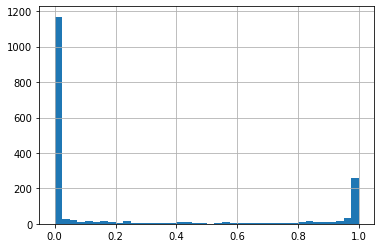

In [32]:
%matplotlib inline
import pylab as plt
print('Expected Papers Accepted:', prob_accept.sum())
prob_accept.hist(bins=40)

## Some Sanity Histograms

Here is the histogram of the reviewer scores after calibration.

Text(0.5, 1.0, 'Calibrated Reviewer Scores')

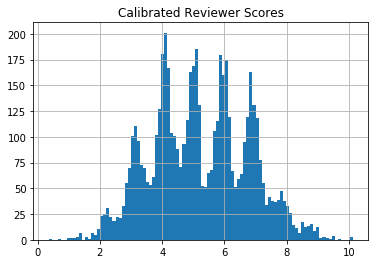

In [33]:
s.hist(bins=100)
plt.title('Calibrated Reviewer Scores')

### Adjustments to Reviewer Scores

We can also compute the posterior distribution for the adjustments to the reviewer scores.

In [34]:
# Compute mean and covariance of review biases
b = pd.Series(np.dot(K_b, alpha), index=X2.index)
covb = alpha_f*(K_b - np.dot(K_b, np.dot(Kinv, K_b)))

In [35]:
reviewer_bias = pd.Series(np.dot(np.diag(1./X2.sum(0)), np.dot(X2.T, b)), index=X2.columns, name='ReviewerBiasMean')
reviewer_bias_std = pd.Series(np.dot(np.diag(1./X2.sum(0)), np.dot(X2.T, np.sqrt(np.diag(covb)))), index=X2.columns, name='ReviewerBiasStd')

Here is a histogram of the mean adjustment for the reviewers.

Text(0.5, 1.0, 'Reviewer Calibration Adjustments Histogram')

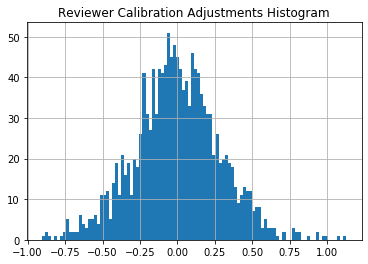

In [36]:
reviewer_bias.hist(bins=100)
plt.title('Reviewer Calibration Adjustments Histogram')

Export a version of the bias scores for use in CMT.

In [37]:
bias_export = pd.DataFrame(data={'Quality Score - Does the paper deserves to be published?':reviewer_bias, 
                   'Impact Score - Independently of the Quality Score above, this is your opportunity to identify papers that are very different, original, or otherwise potentially impactful for the NIPS community.':pd.Series(np.zeros(len(reviewer_bias)), index=reviewer_bias.index),
                    'Confidence':pd.Series(np.zeros(len(reviewer_bias)), index=reviewer_bias.index)})
cols = bias_export.columns.tolist()
cols = [cols[2], cols[1], cols[0]]
bias_export = bias_export[cols]
bias_export.to_csv(os.path.join(cmtutils.cmt_data_directory, 'reviewer_bias.csv'), sep='\t', header=True, index_label='Reviewer Email')

## Sanity Check

As a sanity check Corinna suggested it makes sense to plot the average raw score for the papers vs the probability of accept, just to ensure nothing weird is going on. To clarify the plot, I've actually plotted raw score vs log odds of accept.

 /Users/neil/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning:divide by zero encountered in log


Text(0, 0.5, 'log odds of accept')

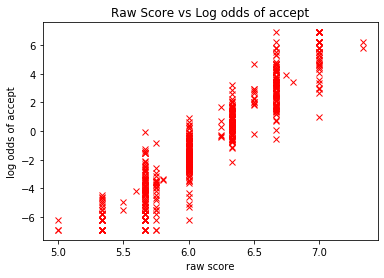

In [38]:
raw_score = pd.DataFrame(np.dot(np.diag(1./X1.sum(0)), np.dot(X1.T, r.Quality)), index=X1.columns)
plt.plot(raw_score, np.log(prob_accept)- np.log(1-prob_accept), 'rx')
plt.title('Raw Score vs Log odds of accept')
plt.xlabel('raw score')
plt.ylabel('log odds of accept')

In [39]:
s.name = 'CalibratedQuality'
r = r.join(s)

We can also look at a scatter plot of the review quality vs the calibrated quality.

Text(0, 0.5, 'calibrated review score')

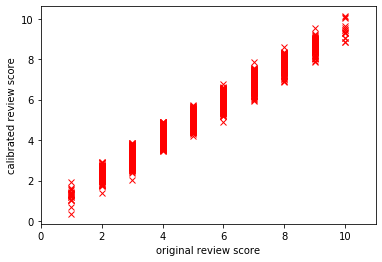

In [40]:
plt.plot(r.Quality, r.CalibratedQuality, 'rx')
plt.xlim([0, 11])
plt.xlabel('original review score')
plt.ylabel('calibrated review score')

## Duplicate Papers

For NIPS 2014 we experimented with duplicate papers: we pushed papers through the system twice, exposing them to different subsets of the reviewers. The first thing we'll look at is the duplicate papers. Firstly we identify them by matching on title.

In [41]:
filename = date + '_paper_list.xls'
papers = cmtutils.cmt_papers_read(filename=filename)
duplicate_list = []
for ID, title in papers.papers.Title.iteritems():
    if int(ID)>1779 and int(ID) != 1949:
        pair = list(papers.papers[papers.papers['Title'].str.contains(papers.papers.Title[ID].strip())].index)
        pair.sort(key=int)
        duplicate_list.append(pair)

Next we compute the correlation coefficients for the duplicated papers for the average impact and quality scores.

In [42]:
quality = []
calibrated_quality = []
accept = []
impact = []
confidence = []
for duplicate_pair in duplicate_list:
    quality.append([np.mean(r[r.PaperID==duplicate_pair[0]].Quality), np.mean(r[r.PaperID==duplicate_pair[1]].Quality)])
    calibrated_quality.append([np.mean(r[r.PaperID==duplicate_pair[0]].CalibratedQuality), np.mean(r[r.PaperID==duplicate_pair[1]].CalibratedQuality)])
    impact.append([np.mean(r[r.PaperID==duplicate_pair[0]].Impact), np.mean(r[r.PaperID==duplicate_pair[1]].Impact)])
    confidence.append([np.mean(r[r.PaperID==duplicate_pair[0]].Conf), np.mean(r[r.PaperID==duplicate_pair[1]].Conf)])
quality = np.array(quality)
calibrated_quality = np.array(calibrated_quality)
impact = np.array(impact)
confidence = np.array(confidence)
quality_cor = np.corrcoef(quality.T)[0, 1]
calibrated_quality_cor = np.corrcoef(calibrated_quality.T)[0, 1]
impact_cor = np.corrcoef(impact.T)[0, 1]
confidence_cor = np.corrcoef(confidence.T)[0, 1]
print("Quality correlation: ", quality_cor)
print("Calibrated Quality correlation: ", calibrated_quality_cor)
print("Impact correlation: ", impact_cor)
print("Confidence correlation: ", confidence_cor)

Quality correlation:  0.5440367486262196
Calibrated Quality correlation:  0.5455958618174278
Impact correlation:  0.26945269236041075
Confidence correlation:  0.3854251559444681


### Correlation Plots

To visualize the quality score correlation we plot the group 1 papers against the group 2 papers. Here we add a small amount of jitter to ensure points to help visualize points that would otherwise fall on the same position.

Text(0.5, 1.0, 'Quality Correlation: 0.5440367486262196')

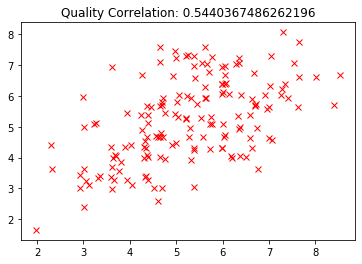

In [43]:
plt.plot(quality[:, 0]+np.random.randn(quality.shape[0])*0.06125, quality[:, 1]+np.random.randn(quality.shape[0])*0.06125, 'rx')
plt.title('Quality Correlation: ' + str(quality_cor))

Similarly for the calibrated quality of the papers.

Text(0.5, 1.0, 'Calibrated Quality Correlation: 0.5455958618174278')

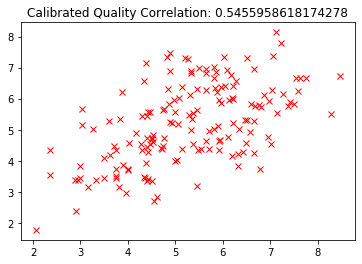

In [44]:
plt.plot(calibrated_quality[:, 0]+np.random.randn(calibrated_quality.shape[0])*0.06125, calibrated_quality[:, 1]+np.random.randn(calibrated_quality.shape[0])*0.06125, 'rx')
plt.title('Calibrated Quality Correlation: ' + str(calibrated_quality_cor))

In [47]:
# Apply Laplace smoothing to accept probabilities before incorporating them.
revs = r.join((prob_accept+0.0002)/1.001, on='PaperID').join(reviewer_bias, on='Email').join(papers.papers['Number Of Discussions'], on='PaperID').join(reviewer_bias_std, on='Email').sort_values(by=['AcceptProbability','PaperID', 'CalibratedQuality'], ascending=False)
revs.set_index(['PaperID'], inplace=True)
def len_comments(x):
    return len(x.Comments)
revs['comment_length']=revs.apply(len_comments, axis=1)
# Save the computed information to disk
revs.to_csv(os.path.join(cmtutils.cmt_data_directory, date + '_processed_reviews.csv'), encoding='utf-8')